In [1]:
## One Model

## https://www.sc-best-practices.org/conditions/differential_gene_expression.html 
## https://www.elucidata.io/blog/navigating-the-single-cell-ship-through-the-pseudo-bulk-route 

## I will switch to a summed approach normalizing for cpm

In [2]:
%%time
# importing our library 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
#from scvi.models.utils import mde
import os
import scipy
from scipy.io import mmread
from scipy.io import mmwrite
import anndata as ad
import warnings 
import psutil
import h5py
import gc
import matplotlib
import re
import seaborn as sns
import rapids_singlecell as rsc



CPU times: user 3.7 s, sys: 1.09 s, total: 4.8 s
Wall time: 46.2 s


## Loading data

In [3]:
data_path = '/data/hadjantalab/lucas/atlas/data/reannotation'

In [4]:
file_path = os.path.join(data_path, 'adata_endo_cohort55-775.h5ad')
adata = ad.read_h5ad(file_path)

In [5]:
adata

AnnData object with n_obs × n_vars = 41667 × 8342
    obs: 'batch', 'stage', 'sample', 'covariate_composite', 'celltype_nowotschin', 'celltype_rosshandler', 'celltype_pijuansala', 'nowotschin_cluster', 'rosshandler_somite_count', 'rosshandler_anatomy', 'rosshandler_phase', 'rosshandler_S_score', 'rosshandler_G2M_score', 'rosshandler_louvain', 'rosshandler_leiden', 'annotation', 'mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_1.0', 'leiden_res_0.95', 'leiden_res_0.9', 'leiden_res_0.85', 'leiden_res_0.8', 'leiden_res_0.75', 'leiden_res_0.7', 'leiden_res_0.65', 'leiden_res_0.6', 'leiden_res_0.55', 'leiden_res_0.5', 'leiden_res_0.45', 'leiden_res_0.4', 'leiden_res_0.35', 'leiden_res_0.3', 'leiden_res_0.25', 'leiden_res_0.2', 'leiden_res_0.15', 'leiden_res_0.1', 'leiden_res_0.05', 'leiden_res_0.0', 'leiden_res_-0.05', 'leiden_res_-

## COMBINING CELL TYPE ANNOTATIONS

In [6]:
adata.obs['annotation_old'] = adata.obs['annotation'].copy()
del adata.obs['annotation']

In [7]:
adata.obs['nn_transfer'] = adata.obs['nn_transfer'].astype('object')
adata.obs['annotation'] = adata.obs['nn_transfer'].fillna(adata.obs['celltype_nowotschin'], inplace=False)

In [8]:
adata.obs['annotation'].value_counts()

exVE    25468
emVE     8209
DE       5961
ParE     1987
VE         42
Name: annotation, dtype: int64

## Creating a pseudobulk object

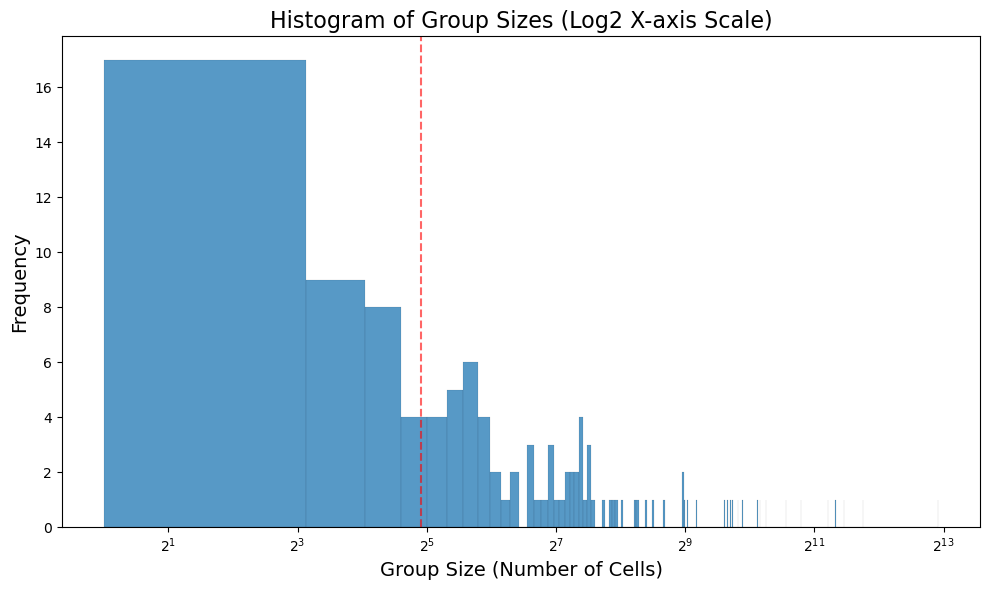

In [9]:
# Step 1: Group the data by 'annotation' and 'covariate_composite'
grouped = adata.obs.groupby(['annotation', 'covariate_composite'], observed=True)

# Step 2: Calculate the size of each group
group_sizes = grouped.size()

# Step 3: Plot the histogram of the group sizes with log2 x-axis scaling
plt.figure(figsize=(10, 6))
sns.histplot(group_sizes, bins=1000, kde=False)  # Plot the raw group sizes

# Set log2 scale for the x-axis
plt.xscale('log', base=2)

# Add a red faint vertical line at x = 30
plt.axvline(x=30, color='red', linestyle='--', alpha=0.6)

# Set plot titles and labels
plt.title('Histogram of Group Sizes (Log2 X-axis Scale)', fontsize=16)
plt.xlabel('Group Size (Number of Cells)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


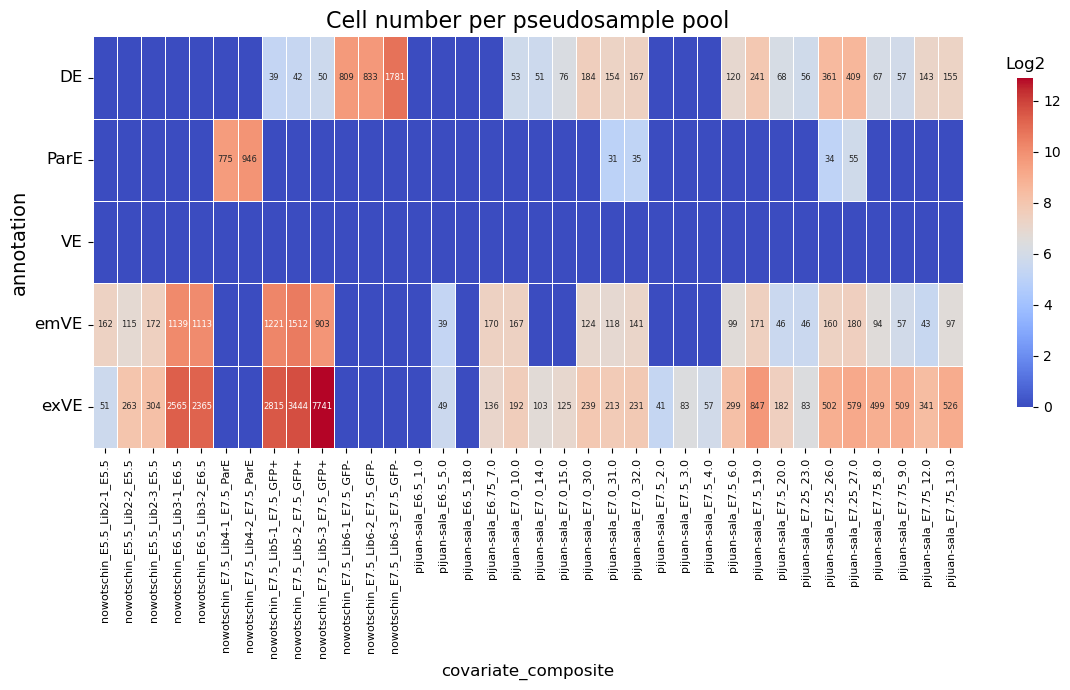

In [10]:

# Assume adata is already loaded and 'obs' contains 'annotation' and 'covariate_composite'
min_cells = int(30)
multiple_sampling = min_cells * 10

# Step 1: Create the contingency table
contingency_table = pd.crosstab(adata.obs['annotation'], adata.obs['covariate_composite'])
contingency_table[contingency_table < min_cells] = 0
contingency_table_log = np.log2(contingency_table + 1)

# Step 2: Calculate sampling frequencies for each group
sampling_frequencies = contingency_table.applymap(lambda x: x if x > 0 else '')

# Step 3: Set the figure size and plot the heatmap
plt.figure(figsize=(12, 7))  # Adjust figure size for better readability

# Create heatmap and use 'annot' to display sampling frequencies
heatmap = sns.heatmap(contingency_table_log,         # Use log-transformed values for color mapping
                      annot=sampling_frequencies,    # Annotate the heatmap with sampling frequencies
                      fmt="",           # No specific formatting
                      cmap="coolwarm",    # Color map for better contrast
                      linewidths=.5,      # Add gridlines for clarity
                      cbar_kws={'shrink': .8},  # Adjust the color bar size
                      annot_kws={"size": 6})  # Set font size for annotations

# Step 4: Add title to the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.set_title('Log2', fontsize=12) 

# Step 5: Adjust axis labels
plt.title('Cell number per pseudosample pool', fontsize=16)
plt.xlabel('covariate_composite', fontsize=12)
plt.ylabel('annotation', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=8)  
plt.yticks(rotation=0, fontsize=12)

# Step 6: Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


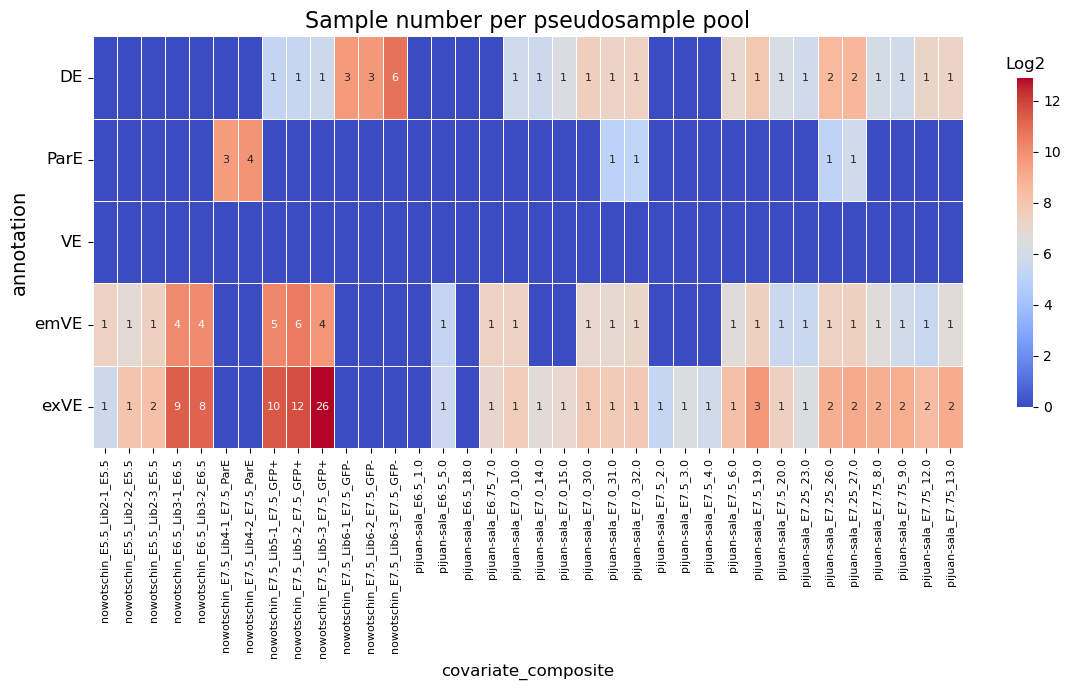

In [11]:

# Assume adata is already loaded and 'obs' contains 'annotation' and 'covariate_composite'
min_cells = int(30)
multiple_sampling = min_cells * 10

# Step 1: Create the contingency table
contingency_table = pd.crosstab(adata.obs['annotation'], adata.obs['covariate_composite'])
contingency_table[contingency_table < min_cells] = 0
contingency_table_log = np.log2(contingency_table + 1)

# Step 2: Calculate sampling frequencies for each group
sampling_frequencies = contingency_table.applymap(lambda x: int(1+ x / multiple_sampling) if x > 0 else '')

# Step 3: Set the figure size and plot the heatmap
plt.figure(figsize=(12, 7))  # Adjust figure size for better readability

# Create heatmap and use 'annot' to display sampling frequencies
heatmap = sns.heatmap(contingency_table_log,         # Use log-transformed values for color mapping
                      annot=sampling_frequencies,    # Annotate the heatmap with sampling frequencies
                      fmt="",           # No specific formatting
                      cmap="coolwarm",    # Color map for better contrast
                      linewidths=.5,      # Add gridlines for clarity
                      cbar_kws={'shrink': .8},  # Adjust the color bar size
                      annot_kws={"size": 8})  # Set font size for annotations

# Step 4: Add title to the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.set_title('Log2', fontsize=12) 

# Step 5: Adjust axis labels
plt.title('Sample number per pseudosample pool', fontsize=16)
plt.xlabel('covariate_composite', fontsize=12)
plt.ylabel('annotation', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=8)  
plt.yticks(rotation=0, fontsize=12)

# Step 6: Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
min_cells = int(30)
multiple_sampling = min_cells*10

# Step 1: Group the data by 'annotation' and 'covariate_composite' and filter by groups with more than 30 cells
grouped = adata.obs.groupby(['annotation', 'covariate_composite'], observed=True).filter(lambda x: len(x) > min_cells)
grouped = grouped.groupby(['annotation', 'covariate_composite'], observed=True)

# Step 2: Create an empty list to store the mean for each batch
aggregated_counts = []

# Step 3: Iterate over each group, sample cells, and calculate the mean of adata.X
for group_name, group_df in grouped:
    # Get the indices of the cells in this group
    group_indices = group_df.index
    
    # Map the string indices to integer positions in adata.obs
    int_indices = np.where(adata.obs.index.isin(group_indices))[0]
    

    ## starting the loop to create multiple samples per composite covariate if cellnumber > 10*min_cells
    for i in range(1+int(len(int_indices)/multiple_sampling)):
        # Determine batch size (500 or the number of available cells if less than 500)
        batch_size = min(multiple_sampling, len(int_indices))
        
        # Sample without replacement
        sampled_indices = np.random.choice(int_indices, batch_size, replace=False)
        
        # Get the corresponding rows from adata.X using the sampled integer indices
        sampled_data = adata.X[sampled_indices, :]
        
        # Ensure the sampled_data is converted to dense if it's sparse
        sampled_data = sampled_data.toarray() if hasattr(sampled_data, "toarray") else sampled_data
        
        # aggregated counts
        aggregated = np.sum(sampled_data, axis = 0)

        # Create the pseudosample name by appending f'sample_{i}' to the group_name tuple
        pseudosample_name = group_name + (f'sample_{i}',)
    
        # Append the results to the list of aggregated_counts (optional: store the group name too)
        aggregated_counts.append((pseudosample_name, aggregated))

# Step 4: Convert the list of tuples into a DataFrame
# The first element of each tuple is the group name (index), and the second is the mean values
X_pseudobulk = pd.DataFrame({group: mean for group, mean in aggregated_counts}).T

# Set the index of the DataFrame to the group names
X_pseudobulk.index = [group for group, _ in aggregated_counts]

# Assign column names to X_pseudobulk if needed (adata.var_names)
X_pseudobulk.columns = adata.var_names

## setting the right index name
X_pseudobulk.index.name = 'faction, sc_sample, pseudo_sample'


In [13]:

# Simulate the index structure you described
# Assuming X_pseudobulk.index is a pandas Index containing tuples
# We need to parse the index correctly and convert the strings to actual tuples

# Clean and split the index to get proper tuples (assuming X_pseudobulk.index contains strings)
#cleaned_index = [(item.split(", ")[0].strip("()'"), item.split(", ")[1].strip("()'")) for item in X_pseudobulk.index]

obs_pseudobulk = pd.DataFrame({
    'faction': [faction for faction, sc_sample, pseudo_sample in X_pseudobulk.index],
    'sc_sample': [sc_sample for faction, sc_sample, pseudo_sample in X_pseudobulk.index],
    'pseudo_sample': [pseudo_sample for faction, sc_sample, pseudo_sample in X_pseudobulk.index], 
    'dependent_pseudosamples': [f'faction{faction}_{sc_sample}' for faction, sc_sample, pseudo_sample in X_pseudobulk.index],
    'batch': [sc_sample.split('_')[0] for faction, sc_sample, pseudo_sample in X_pseudobulk.index],  # Extract batch
    'stage': [sc_sample.split('_')[1] for faction, sc_sample, pseudo_sample in X_pseudobulk.index],  # Extract batch
}, index=X_pseudobulk.index)


In [14]:
# Apply a function to ensure all index elements are converted to strings, even if they're complex types
obs_pseudobulk.index = obs_pseudobulk.index.map(lambda x: str(x))
X_pseudobulk.index = X_pseudobulk.index.map(lambda x: str(x))


## Scaling (CPM), filtering lowly expressed genes, Log2+1 

In [15]:
## COUNTS PER MILLION
X_pseudobulk = X_pseudobulk.apply(lambda x: x * ( 1e6 / x.sum()), axis=1)

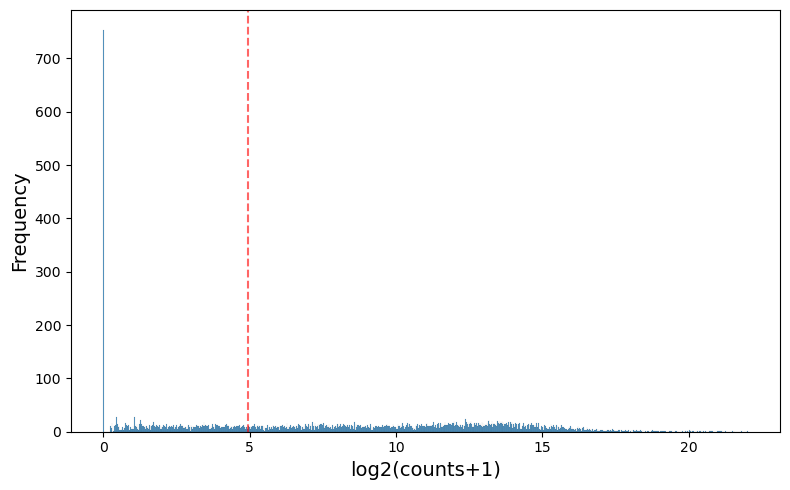

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log2(X_pseudobulk.sum(axis=0)+1), bins=1000, kde=False)  # Plot the raw group sizes

# Add a red faint vertical line at x = 30
plt.axvline(x=np.log2(30+1), color='red', linestyle='--', alpha=0.6)

# Set plot titles and labels
plt.xlabel('log2(counts+1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
## Filtering genes that have less than 30 counts across all samples
X_pseudobulk = X_pseudobulk.loc[:, X_pseudobulk.sum(axis=0) >= 30]
X_pseudobulk.shape

(184, 5627)

Text(0, 0.5, 'highest gene count / sum of counts')

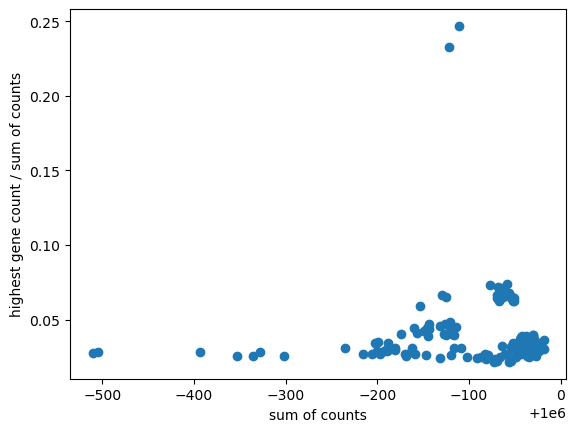

In [18]:
# checking highly expressed genes
plt.scatter(y=X_pseudobulk.max(axis=1)/X_pseudobulk.sum(axis=1), x = X_pseudobulk.sum(axis=1))
plt.xlabel('sum of counts')
plt.ylabel('highest gene count / sum of counts')

In [19]:
## log2 transform
X_pseudobulk = np.log2(X_pseudobulk+1)

## Checking PCA

In [20]:
adata_pb = ad.AnnData(X = X_pseudobulk, obs = obs_pseudobulk)

In [21]:
## normalize and pca
sc.pp.pca(adata_pb)

In [22]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.X, axis=1)

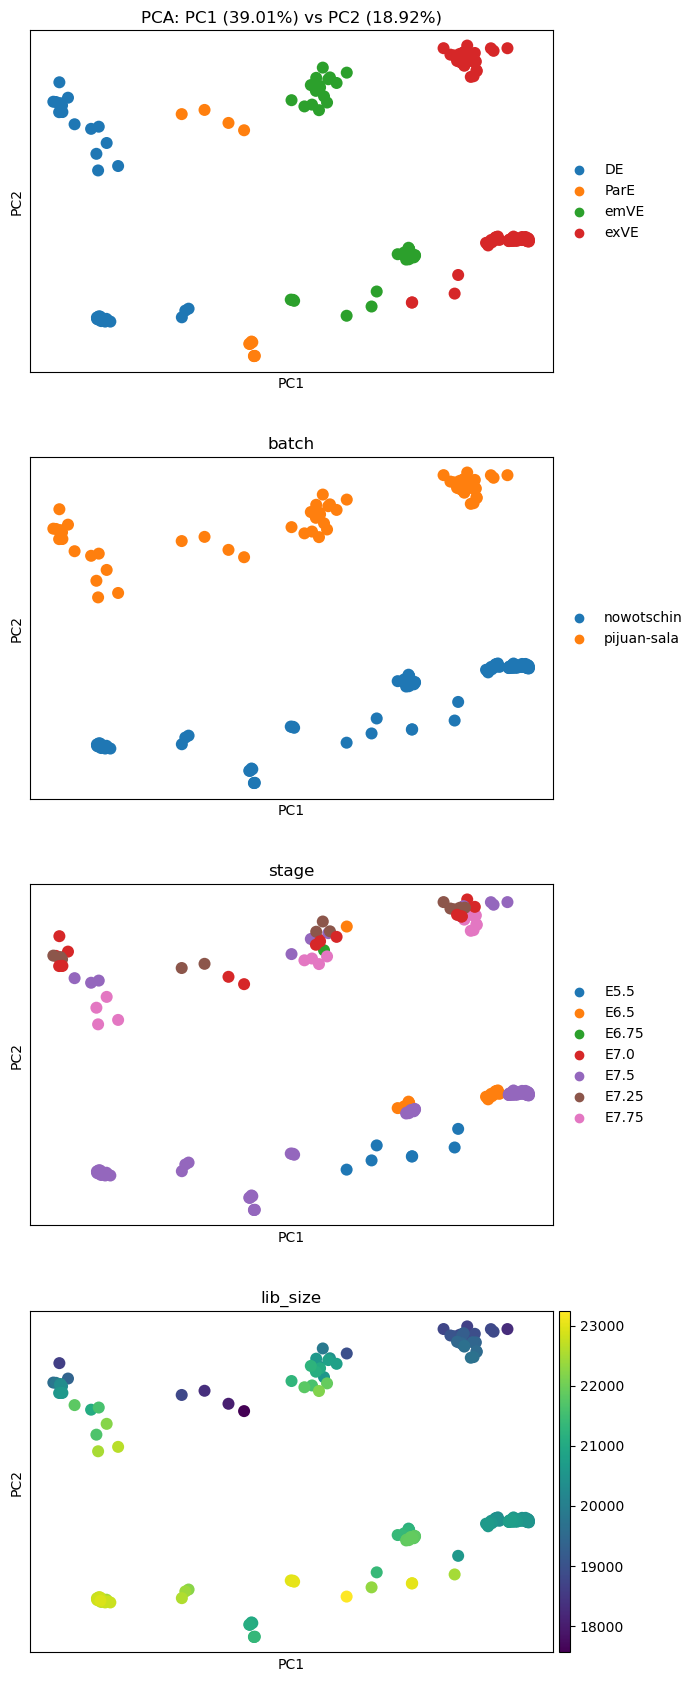

In [23]:
# Extract variance ratios
variance_ratios = adata_pb.uns['pca']['variance_ratio']
pc1_variance = variance_ratios[0] * 100  # Percentage for PC1
pc2_variance = variance_ratios[1] * 100  # Percentage for PC2

# Plot PCA and display variance in axis labels
plots = ['faction', 'batch', 'stage', 'lib_size']
sc.pl.pca(
    adata_pb,
    color=plots,
    ncols=1,
    size=300,
    components=['1,2'],  # We are interested in PC1 and PC2
    title=f'PCA: PC1 ({pc1_variance:.2f}%) vs PC2 ({pc2_variance:.2f}%)'
)

## DIFFERENTIAL TESTING

In [24]:
# this paper, time series should hold the key to incorporate multiple pseudosamples per sample
##https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/
# https://www.bioconductor.org/packages//2.11/bioc/vignettes/limma/inst/doc/usersguide.pdf   chapter 10.3
# https://www.bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf another limma vignette


## https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html  approach 4.5 aint working not full rank

## https://bioconductor.org/books/3.15/OSCA.multisample/multi-sample-comparisons.html#performing-the-de-analysis  GOOD READ

In [25]:
import os
os.environ['R_HOME'] = '/home/schroel1/miniconda3/envs/gpu2/lib/R'
os.environ['R_USER'] = '/home/schroel1/miniconda3/envs/gpu2/lib/R'

import rpy2
import anndata2ri
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.robjects as ro

#anndata2ri.activate() ## apparently leads to issues
#pandas2ri.activate() ## apparentl


%load_ext rpy2.ipython


In [26]:
## transposing X for limma
X_pseudobulk = X_pseudobulk.T

In [27]:
#seems to be necessary for snippet below

# Disable R from trying to create a graphics device
ro.r('pdf(NULL)')  # Redirects plotting output to null device
ro.r('dev.control(displaylist="inhibit")')  # Prevents the use of dev.off()

# Now execute your main code


<rpy2.rinterface_lib.sexp.NULLType object at 0x2b31a598d540> [RTYPES.NILSXP]

In [28]:
%%time
%%R -i obs_pseudobulk -i X_pseudobulk -o dge_results

# Load necessary library
library(limma)

# Step 1: Get the unique factions from the `obs_pseudobulk` dataframe
factions <- unique(obs_pseudobulk$faction)


# Create list to store results
dge_results <- list()

# Loop over each faction
for (faction in factions) {
    
    # Dynamically create a one_vs_all variable
    faction_of_interest <- ifelse(obs_pseudobulk$faction == faction, 1, 0)
      
    # Create design matrix
    design <- model.matrix(~0 + batch + stage + faction_of_interest, obs_pseudobulk)
    colnames(design) <- make.names(colnames(design))
    
    # Define the block and calculate duplicate correlation
    block <- obs_pseudobulk$sc_sample
    cor <- duplicateCorrelation(X_pseudobulk, design, block=block)
    print(paste('Consensus Correlation', toString(cor$consensus.correlation)))

    # Fit the limma model
    fit <- lmFit(X_pseudobulk, design=design, block=block, correlation=cor$consensus.correlation)

    # Create contrast for this faction vs all others
    contrast_matrix <- makeContrasts(faction_of_interest, levels=colnames(design))
    
    # Apply the contrast to the fit model
    fit2 <- contrasts.fit(fit, contrast_matrix)
    
    # Apply empirical Bayes moderation
    fit2 <- eBayes(fit2)
    
    # Extract the results for the current faction vs all others
    results_faction_vs_rest <- topTable(fit2, adjust="BH", number=Inf)
    
    # Store results in the list
    dge_results[[faction]] <- results_faction_vs_rest
}


[1] "Consensus Correlation 0.408754052882729"
[1] "Consensus Correlation 0.338434831002109"
[1] "Consensus Correlation 0.457436837236118"
[1] "Consensus Correlation 0.455515120300538"
CPU times: user 10min 15s, sys: 16.2 s, total: 10min 31s
Wall time: 1min 5s


## Getting and checking result

In [29]:
## converting the R tables back to pandas

# Activate the automatic conversion between R and pandas
pandas2ri.activate()

# Import the R 'base' and 'methods' packages
base = ro.packages.importr('base')

# Convert the R objects to pandas DataFrames
dge_results_py = {}
for key in dge_results:
    # Convert the 'DESeqResults' RS4 object to a data frame using 'as.data.frame' in R
    dge_results_r_df = base.as_data_frame(dge_results[key])  # Converts RS4 to R dataframe
    
    # Convert the R dataframe to pandas dataframe
    dge_results_py[key] = ro.conversion.rpy2py(dge_results_r_df)

# Verify that the conversion worked by printing the type and first few rows
for faction_name, df in dge_results_py.items():
    print(f"Results for {faction_name}:")
    print(type(df))  # Check that this is a pandas DataFrame
    print(df.head())  # Display the first few rows of the dataframe


Results for DE:
<class 'pandas.core.frame.DataFrame'>
            logFC    AveExpr          t        P.Value      adj.P.Val  \
Xlr4b   -3.779840   6.222089 -48.997654  3.319713e-105  1.868003e-101   
Mageb16 -4.929439   5.490782 -46.891259  4.704175e-102   1.323520e-98   
Nostrin -4.790973   4.892219 -43.651474   5.786140e-97   1.085287e-93   
Rhox5   -5.134270  10.190437 -42.918002   9.086363e-96   1.278224e-92   
Vkorc1  -2.404375   8.661506 -42.203186   1.381355e-94   1.554576e-91   

                  B  
Xlr4b    229.867238  
Mageb16  222.675071  
Nostrin  211.043007  
Rhox5    208.307175  
Vkorc1   205.602662  
Results for ParE:
<class 'pandas.core.frame.DataFrame'>
           logFC   AveExpr           t        P.Value      adj.P.Val  \
Ptk6    6.539496  0.398350  106.527845  7.090111e-163  3.989605e-159   
Tpbgl   6.970068  0.481146   99.977788  4.629042e-158  1.302381e-154   
C2cd4a  6.203289  0.387188   91.287282  3.518618e-151  6.599755e-148   
Grem2   7.799533  0.544928   74

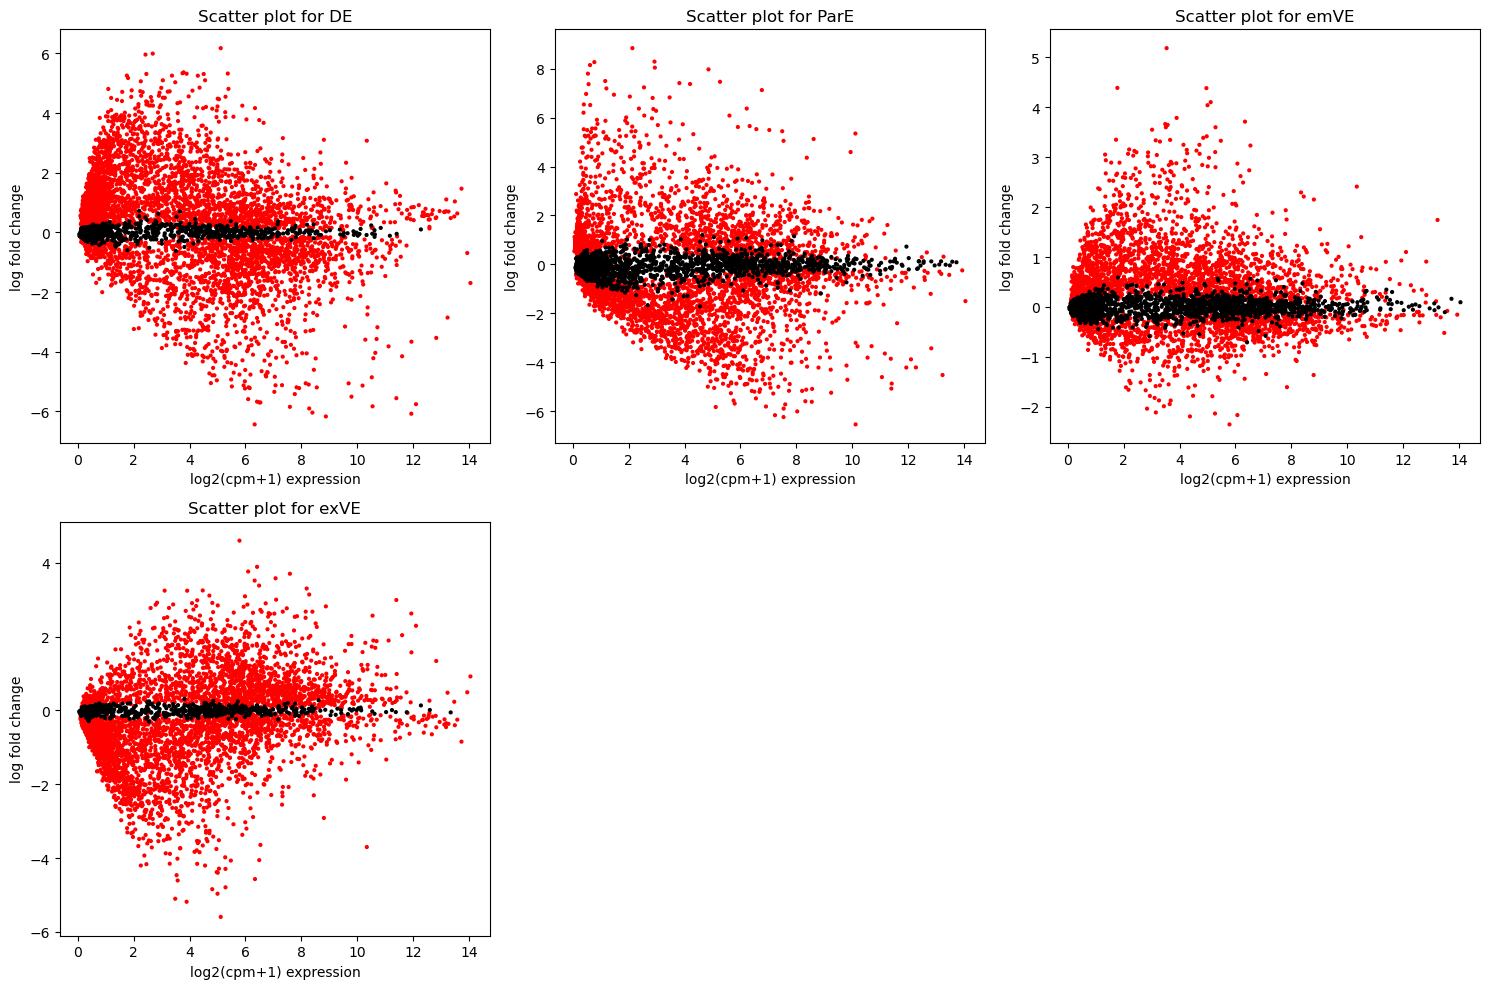

In [30]:
# Define the number of plots per row
plots_per_row = 3
num_plots = len(dge_results_py)
rows = (num_plots // plots_per_row) + (num_plots % plots_per_row > 0)

# Create subplots grid
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, 5 * rows))  # Adjust size as needed

# Flatten axes array if there are multiple rows
axes = axes.flatten()

# Plot each dataframe
for idx, (name, df) in enumerate(dge_results_py.items()):
    # Create a condition where the color is assigned based on the adjusted p-value
    significant = np.where(df['adj.P.Val'] < 0.1, 'red', 'black')

    # Create scatter plot in the corresponding subplot
    axes[idx].scatter(df['AveExpr'], df['logFC'], color=significant, s=4)

    # Add labels and title for clarity
    axes[idx].set_xlabel('log2(cpm+1) expression')
    axes[idx].set_ylabel('log fold change')
    axes[idx].set_title(f'Scatter plot for {name}')

# Hide any empty subplots
for ax in axes[num_plots:]:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the entire figure
plt.show()

## Extracting different sets of results

In [57]:
## extracting all the transcription factors from my results
## list from https://amigo.geneontology.org/amigo/term/GO:0003700 
from pybiomart import Server

# Load transcription factors data
file_path = os.path.join(data_path, 'transcription_factors.csv')
transcription_factors_table = pd.read_table(file_path, sep=',')

# Function to extract the correct MGI ID, handling cases like 'MGI:MGI:95388'
def extract_mgi_id(mgi_string):
    # Find the last occurrence of 'MGI:' and extract it with the following ID
    return 'MGI:' + mgi_string.split('MGI:')[-1]

# Apply the extraction of the MGI ID
transcription_factors_table['MGI ID'] = transcription_factors_table['bioentity'].apply(extract_mgi_id)

# Connect to the Ensembl BioMart server
server = Server(host='http://www.ensembl.org')

# Access the Mouse (Mus musculus) dataset
mart = server.marts['ENSEMBL_MART_ENSEMBL']
dataset = mart.datasets['mmusculus_gene_ensembl']

# Query BioMart to get all MGI IDs and corresponding HGNC symbols
# Get all entries with MGI ID and HGNC symbol (for human genes)
biomart_results = dataset.query(attributes=['mgi_id', 'mgi_symbol'])

# Filter BioMart results to include only MGI IDs present in the 'transcription_factors_table' DataFrame
biomart_results = biomart_results[biomart_results['MGI ID'].isin(transcription_factors_table['MGI ID'])]

# Merge the filtered BioMart results with the transcription factors DataFrame
transcription_factors_table = transcription_factors_table.merge(biomart_results, on='MGI ID', how='left')

## extract all the unique mgi symbols from my table
transcription_factors = set(transcription_factors_table['MGI symbol'])

In [31]:
# Merge the filtered BioMart results with the transcription factors DataFrame
file_path = os.path.join(data_path, 'transcription_factors.csv')
transcription_factors_table = pd.read_table(file_path, sep = ',')

## extract all the unique mgi symbols from my table
transcription_factors = set(transcription_factors_table['MGI symbol'])

In [33]:
# Create a temporary dictionary to store the new dataframes
dge_results_significant = {}

# Loop through all dataframes in dge_results_py
for key, df in dge_results_py.items():
    # Check if the 'padj' column exists in the dataframe to avoid errors
    if 'adj.P.Val' in df.columns:
        # Extract the rows where 'padj' is less than 0.1
        significant_df = df[df['adj.P.Val'] < 0.1]
        
        # Create a new key with the "_significant" suffix
        significant_key = f"{key}"
        
        # Store the new dataframe in the temporary dictionary
        dge_results_significant[significant_key] = significant_df



# Verify the new dataframes have been added
for key, df in dge_results_significant.items():
    print(f"Dataframe for {key}:")
    print(df)  # Show the first few rows of each dataframe


Dataframe for DE:
            logFC    AveExpr          t        P.Value      adj.P.Val  \
Xlr4b   -3.779840   6.222089 -48.997654  3.319713e-105  1.868003e-101   
Mageb16 -4.929439   5.490782 -46.891259  4.704175e-102   1.323520e-98   
Nostrin -4.790973   4.892219 -43.651474   5.786140e-97   1.085287e-93   
Rhox5   -5.134270  10.190437 -42.918002   9.086363e-96   1.278224e-92   
Vkorc1  -2.404375   8.661506 -42.203186   1.381355e-94   1.554576e-91   
...           ...        ...        ...            ...            ...   
Nav3    -0.172551   0.463041  -1.740067   8.357709e-02   9.894557e-02   
Ece1    -0.459702   3.440486  -1.739055   8.375540e-02   9.913580e-02   
Pde10a   0.314309   0.681027   1.737101   8.410065e-02   9.952352e-02   
Nsun2    0.172329   8.290391   1.736919   8.413290e-02   9.954075e-02   
Lmod1    0.225089   0.795991   1.735753   8.433957e-02   9.976430e-02   

                  B  
Xlr4b    229.867238  
Mageb16  222.675071  
Nostrin  211.043007  
Rhox5    208.3071

In [34]:
# Assume transcription_factors is a list containing the gene names to filter by
# transcription_factors = ['gene1', 'gene2', ...]

# Create a new dictionary to store the filtered dataframes
dge_results_transcription = {}

# Loop through all significant dataframes in dge_results_significant
for key, df in dge_results_py.items():
    # Filter the dataframe to include only rows where the gene name (index) is in the transcription_factors list
    transcription_df = df[df.index.isin(transcription_factors)]
    
    # Create a new key with the "_transcription" suffix
    transcription_key = f"{key}"
    
    # Store the filtered dataframe in the new dictionary
    dge_results_transcription[transcription_key] = transcription_df


In [35]:
# Assume transcription_factors is a list containing the gene names to filter by
# transcription_factors = ['gene1', 'gene2', ...]

# Create a new dictionary to store the filtered dataframes
dge_results_transcription_significant = {}

# Loop through all significant dataframes in dge_results_significant
for key, df in dge_results_significant.items():
    # Filter the dataframe to include only rows where the gene name (index) is in the transcription_factors list
    transcription_df = df[df.index.isin(transcription_factors)]
    
    # Create a new key with the "_transcription" suffix
    transcription_key = f"{key}"
    
    # Store the filtered dataframe in the new dictionary
    dge_results_transcription_significant[transcription_key] = transcription_df


In [36]:
## ORDER ALL MY TABLES
dge_results_py = sorted(dge_results_py.items(), key=lambda x: x[0])
dge_results_py = dict(dge_results_py)

dge_results_significant = sorted(dge_results_significant.items(), key=lambda x: x[0])
dge_results_significant = dict(dge_results_significant)

dge_results_transcription = sorted(dge_results_transcription.items(), key=lambda x: x[0])
dge_results_transcription = dict(dge_results_transcription)

dge_results_transcription_significant = sorted(dge_results_transcription_significant.items(), key=lambda x: x[0])
dge_results_transcription_significant = dict(dge_results_transcription_significant)


## SAVE RESULTS

In [38]:
data_path = '/data/hadjantalab/lucas/atlas/data/reannotation'

In [39]:
## SAVING THE COMPLETE RESULTS

file_path = os.path.join(data_path, "dge_endo_cohort55-775.xlsx")
# Create a Pandas Excel writer object
with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in dge_results_py.items():
        # Write each dataframe to a different sheet
        sheet_name = sheet_name[-30:]
        df.to_excel(writer, sheet_name=sheet_name)


In [40]:
## SAVING sig

file_path = os.path.join(data_path, "dge_endo_cohort55-775_significant.xlsx")
# Create a Pandas Excel writer object
with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in dge_results_significant.items():
        # Write each dataframe to a different sheet
        sheet_name = sheet_name[-30:]
        df.to_excel(writer, sheet_name=sheet_name)


In [41]:
## SAVING TF

file_path = os.path.join(data_path, "dge_endo_cohort55-775_transcription.xlsx")
# Create a Pandas Excel writer object
with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in dge_results_transcription.items():
        # Write each dataframe to a different sheet
        sheet_name = sheet_name[-30:]
        df.to_excel(writer, sheet_name=sheet_name)


In [42]:
## SAVING TF significant

file_path = os.path.join(data_path, "dge_endo_cohort55-775_transcription_significant.xlsx")
# Create a Pandas Excel writer object
with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in dge_results_transcription_significant.items():
        # Write each dataframe to a different sheet
        sheet_name = sheet_name[-30:]
        df.to_excel(writer, sheet_name=sheet_name)
